In [7]:
import zipfile
import os

def un_zip(file_name, dst):
    """解压 zip 文件"""
    zip_file = zipfile.ZipFile(file_name)
    if os.path.isdir(dst):
        pass
    else:
        os.mkdir(dst)
    for names in zip_file.namelist():
        zip_file.extract(names, dst)
    zip_file.close()

if __name__ == '__main__':
    file_name = r"flower_photos.zip"
    dst = r"flower"
    un_zip(file_name, dst)

In [9]:
pip install --upgrade pip

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 2.1 MB 70.1 MB/s eta 0:00:01B/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install ipykernel

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install split-folders

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [5]:
import splitfolders
#train:test=8:2
splitfolders.ratio(input='flower/flower_photos',output='output',seed=1337,ratio=(0.8,0.2))

Copying files: 3670 files [00:00, 5920.64 files/s]


训练数据集数量： 93888
测试数据集数量： 736
通道数/图像长/宽： (3, 224, 224)
一张图像的标签样式： 0


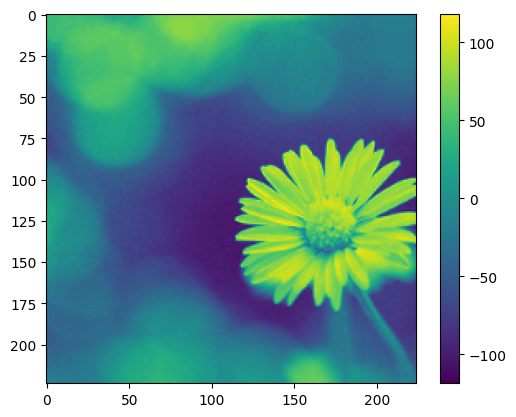

In [6]:
# 隐藏警告
import warnings
warnings.filterwarnings('ignore')
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#os模块主要用于处理文件和目录
import os
import numpy as np
import matplotlib.pyplot as plt
import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
from mindspore.dataset.vision import c_transforms as vision
from mindspore import context
import mindspore.nn as nn
from mindspore.train import Model
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig,LossMonitor
from mindspore import Tensor
from mindspore.train.serialization import export
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import mindspore.ops as ops
# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

cfg = edict({
'data_path': 'output/train', #训练数据集
'test_path':'output/val', #测试数据集
'data_size': 3616,
'HEIGHT': 224, # 图片高度
'WIDTH': 224, # 图片宽度
'_R_MEAN': 123.68,
'_G_MEAN': 116.78,
'_B_MEAN': 103.94,
'_R_STD': 1,
'_G_STD': 1,
'_B_STD':1,
'_RESIZE_SIDE_MIN': 256,
'_RESIZE_SIDE_MAX': 512,
'batch_size': 32,
'num_class': 5, # 分类类别
'epoch_size': 150, # 训练次数
'loss_scale_num':1024,
'prefix': 'resnet-ai',
'directory': './model_resnet',
'save_checkpoint_steps': 10,
})

# 数据处理
def read_data(path,config,usage="train"):
    #从目录中读取图像的源数据集。
    dataset = ds.ImageFolderDataset(path,class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
    # define map operations
    decode_op = vision.Decode()
    normalize_op = vision.Normalize(mean=[cfg._R_MEAN, cfg._G_MEAN,cfg._B_MEAN], std=[cfg._R_STD, cfg._G_STD, cfg._B_STD])
    resize_op = vision.Resize(cfg._RESIZE_SIDE_MIN)
    center_crop_op = vision.CenterCrop((cfg.HEIGHT, cfg.WIDTH))
    horizontal_flip_op = vision.RandomHorizontalFlip()
    channelswap_op = vision.HWC2CHW()
    random_crop_decode_resize_op = vision.RandomCropDecodeResize((cfg.HEIGHT,cfg.WIDTH), (0.5, 1.0), (1.0, 1.0), max_attempts=100)
    if usage == 'train':
        dataset = dataset.map(input_columns="image",operations=random_crop_decode_resize_op)
        dataset = dataset.map(input_columns="image",operations=horizontal_flip_op)
    else:
        dataset = dataset.map(input_columns="image", operations=decode_op)
        dataset = dataset.map(input_columns="image", operations=resize_op)
        dataset = dataset.map(input_columns="image", operations=center_crop_op)
        
    dataset = dataset.map(input_columns="image", operations=normalize_op)
    dataset = dataset.map(input_columns="image", operations=channelswap_op)
    
    if usage == 'train':
        dataset = dataset.shuffle(buffer_size=10000) # 10000 as in imageNet train script
        dataset = dataset.batch(cfg.batch_size, drop_remainder=True)
    else:
        dataset = dataset.batch(1, drop_remainder=True)
        
    dataset = dataset.repeat(1)
    dataset.map_model = 4
    return dataset

ds_train = read_data(cfg.data_path,cfg,usage="output/train")
ds_test = read_data(cfg.test_path,cfg,usage="output/val")
step_size=ds_train.get_dataset_size()
print('训练数据集数量：',ds_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',ds_test.get_dataset_size())
de_dataset = ds_train
data_next = de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'][0,...].shape)
print('一张图像的标签样式：', data_next['label'][0]) # 一共5类，用0-4的数字表达类别。
plt.figure()
plt.imshow(data_next['image'][0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
#构建网络
#构建残差网络结构
from typing import Type, Union, List, Optional
from mindvision.classification.models.blocks import ConvNormActivation
from mindvision.classification.models.classifiers import BaseClassifier
from mindvision.classification.models.head import DenseHead
from mindvision.classification.models.neck import GlobalAvgPooling
from mindvision.classification.utils.model_urls import model_urls
from mindvision.utils.load_pretrained_model import LoadPretrainedModel
from mindspore import nn

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel, kernel_size=3, stride=stride, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,kernel_size=3, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层

        if self.down_sample:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out
    
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d

        self.conv1 = ConvNormActivation(in_channel, out_channel,kernel_size=1, norm=norm)
        self.conv2 = ConvNormActivation(out_channel, out_channel,kernel_size=3, stride=stride, norm=norm)
        self.conv3 = ConvNormActivation(out_channel, out_channel * self.expansion, kernel_size=1, norm=norm, activation=None)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.conv3(out)  # 主分支第三层：1*1卷积层

        if self.down_sample:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out
    
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    if stride != 1 or last_out_channel != channel * block.expansion:
        down_sample = ConvNormActivation(last_out_channel, channel * block.expansion,kernel_size=1, stride=stride, norm=nn.BatchNorm2d, activation=None)

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample, norm=nn.BatchNorm2d))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):
        layers.append(block(in_channel, channel, norm=nn.BatchNorm2d))

    return nn.SequentialCell(layers)


class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],layer_nums: List[int], norm: Optional[nn.Cell] = None) -> None:
        super(ResNet, self).__init__()
        if not norm:
            norm = nn.BatchNorm2d
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = ConvNormActivation(3, 64, kernel_size=7, stride=2, norm=norm)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义，
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)

    def construct(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

def _resnet(arch: str, block: Type[Union[ResidualBlockBase, ResidualBlock]], layers: List[int], num_classes: int, pretrained: bool, input_channel: int):
    backbone = ResNet(block, layers)
    neck = GlobalAvgPooling()  # 平均池化层
    head = DenseHead(input_channel=input_channel, num_classes=num_classes)  # 全连接层
    model = BaseClassifier(backbone, neck, head)  # 将backbone层、neck层和head层连接起来

    if pretrained:
        # 下载并加载预训练模型
        LoadPretrainedModel(model, model_urls[arch]).run()

    return model

def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    return _resnet("resnet50", ResidualBlock, [3, 4, 6, 3], num_classes, pretrained, 2048)

In [ ]:
from mindspore.train import Model
from mindvision.engine.callback import ValAccMonitor

# 定义ResNet50网络
network = resnet50(pretrained=True)

# 全连接层输入层的大小
in_channel = network.head.dense.in_channels
head = DenseHead(input_channel=in_channel, num_classes=5)
# 重置全连接层
network.head = head
# 设置学习率
num_epochs = 20
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size * num_epochs,step_per_epoch=step_size, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 实例化模型
model = Model(network, loss, opt, metrics={"Accuracy": nn.Accuracy()})
# 模型训练
model.train(num_epochs, ds_train, callbacks=[ValAccMonitor(model, ds_test, num_epochs)])

--------------------
Epoch: [  1 /  20], Train Loss: [1.094], Accuracy:  0.308
--------------------
Epoch: [  2 /  20], Train Loss: [0.022], Accuracy:  0.565
--------------------
Epoch: [  3 /  20], Train Loss: [0.651], Accuracy:  0.541
--------------------
Epoch: [  4 /  20], Train Loss: [1.389], Accuracy:  0.598
--------------------
Epoch: [  5 /  20], Train Loss: [0.021], Accuracy:  0.577
--------------------
Epoch: [  6 /  20], Train Loss: [0.018], Accuracy:  0.701
--------------------
Epoch: [  7 /  20], Train Loss: [0.510], Accuracy:  0.613
--------------------
Epoch: [  8 /  20], Train Loss: [0.001], Accuracy:  0.613
--------------------
Epoch: [  9 /  20], Train Loss: [0.195], Accuracy:  0.645
--------------------
Epoch: [ 10 /  20], Train Loss: [0.001], Accuracy:  0.629
--------------------
Epoch: [ 11 /  20], Train Loss: [0.001], Accuracy:  0.664
--------------------
Epoch: [ 12 /  20], Train Loss: [0.000], Accuracy:  0.639
--------------------
Epoch: [ 13 /  20], Train Loss:

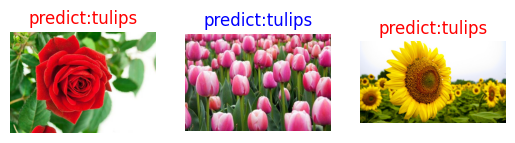

In [9]:
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np 
from mindspore import Tensor 
from mindspore import load_checkpoint, load_param_into_net

def visualize_model(best_ckpt_path, image_paths): 
    num_class = 5
    net = resnet50(num_class) # 加载模型参数 
    param_dict = load_checkpoint(best_ckpt_path) 
    load_param_into_net(net, param_dict) 
    model = Model(net) # 预处理图片并进行预测 
    # 标签名称映射
    class_names = {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
    images = [] 
    labels = [] # 存储标签名称
    for path in image_paths: 
        image = Image.open(path) 
        image = image.resize((224, 224)) 
        image = np.array(image) 
        image = np.transpose(image, (2, 0, 1)) 
        image = image.astype(np.float32) 
        image = (image / 255 - 0.5) / 0.5 # 标准化 
        images.append(image)
        label = path.split('/')[-1].split('.')[0] # 获取标签名称
        labels.append(label) 
    images = np.array(images) 
    output = model.predict(Tensor(images)) 
    preds = np.argmax(output.asnumpy(), axis=1) # 显示图片及预测结果 
    plt.figure() 
    for i in range(len(image_paths)): 
        plt.subplot(2, 3, i+1) 
        if preds[i] == class_names[labels[i]]:
            color = 'blue' # 蓝色代表预测正确
        else:
            color = 'red' # 红色代表预测错误
        plt.title('predict:{}'.format(list(class_names.keys())[list(class_names.values()).index(preds[i])]), color=color) # 输出预测正确的名称
        image = Image.open(image_paths[i]) 
        plt.imshow(image) 
        plt.axis('off') 
    plt.show()

image_paths = ['roses.jpg','tulips.jpg','sunflowers.jpg'] 
visualize_model('best.ckpt', image_paths)

In [10]:
import os
#创建文件夹
if not os.path.exists('./flowers/'):
    os.mkdir('./flowers/')
param_dict = load_checkpoint(os.path.join('best.ckpt'))
# load the parameter into net
resnet=resnet50(num_classes=cfg.num_class)
load_param_into_net(resnet, param_dict)
x = np.random.uniform(-1.0, 1.0, size = [1, 3, cfg.HEIGHT,cfg.WIDTH]).astype(np.float32)
export(resnet, Tensor(x), file_name = './flowers/best_model.onnx',file_format = 'ONNX')

In [11]:
import moxing
import os
moxing.file.copy_parallel(src_url='./flowers/best_model.onnx',dst_url='s3://wlm-obs-hx/flower/onnx/best_model.onnx')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1
